In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import os

import seaborn as sns

plt.rcParams['figure.dpi'] = 300

## 1. Loading in Met Data

In [2]:
met_folder = './airstrip_metdata'
met_files = os.listdir(met_folder)
met_files = [f for f in met_files if f.endswith('.tsv')]

# remove 2020 due to bad data
met_files = [f for f in met_files if '2020' not in f]  # put aside 2022 so we can use it later

# read in files...
met_dfs = []
for f in met_files[:-2]:
    met_dfs.append(pd.read_csv(os.path.join(met_folder, f), sep='\t', header=0, encoding='ISO-8859-1'))
    # use only the precip and temp columns and rename to something more intuitive
    # units: temp (degC), rainfall (mm)
    met_dfs[-1] = met_dfs[-1][['Time', 'AirTC_1_Avg: Airstrip-15min, (°C)', 'Rain_mm_Tot: Airstrip-15min, (mm)']].rename(columns={'Time': 'datetime', 'AirTC_1_Avg: Airstrip-15min, (°C)': 'Temp', 'Rain_mm_Tot: Airstrip-15min, (mm)': 'Precip'})

# parse datetimes
for i in range(len(met_dfs)):
    met_dfs[i]['datetime'] = pd.to_datetime(met_dfs[i]['datetime'], format='%Y-%m-%d %H:%M:%S')

In [3]:
# load up the 2022 SHIFT data
met_df_shift = pd.read_csv(os.path.join(met_folder, met_files[-2]), sep='\t', header=0, encoding='ISO-8859-1')
met_df_shift = met_df_shift[['Time', 'AirTC_1_Avg: Airstrip-15min, (°C)', 'Rain_mm_Tot: Airstrip-15min, (mm)']].rename(columns={'Time': 'datetime', 'AirTC_1_Avg: Airstrip-15min, (°C)': 'Temp', 'Rain_mm_Tot: Airstrip-15min, (mm)': 'Precip'})
met_df_shift['datetime'] = pd.to_datetime(met_df_shift['datetime'], format='%Y-%m-%d %H:%M:%S')

## 2. Average Precipitation

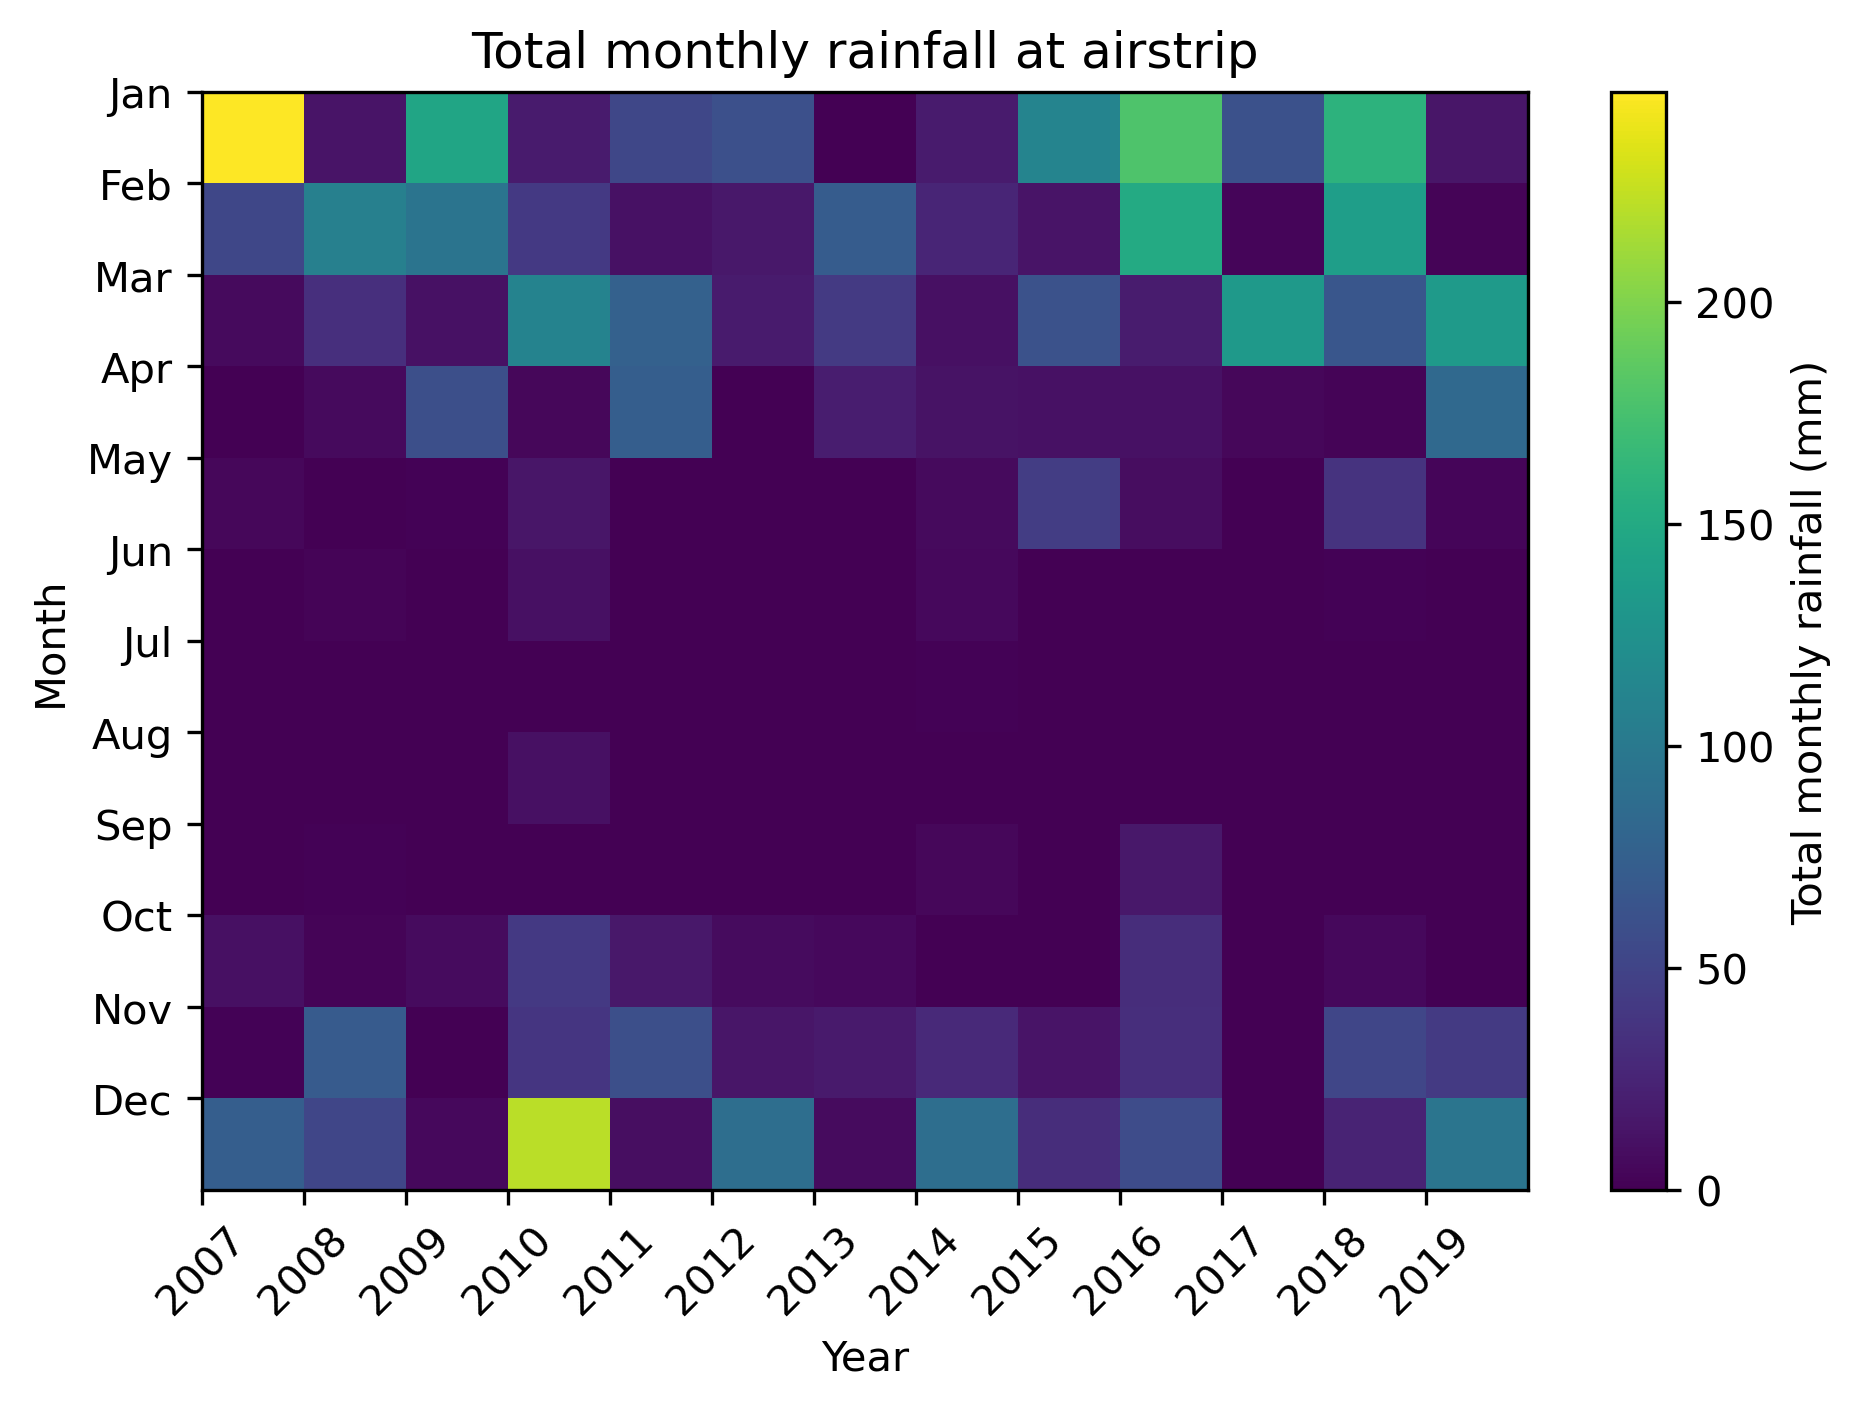

In [4]:
## try monthly averages of precip
n_int = 12

monthly_precips = np.zeros([n_int, len(met_dfs)])

# get cumulative rainfall for each month for each year
for i in range(len(met_dfs)):
    for j in range(n_int):
        monthly_precips[j, i] = met_dfs[i][met_dfs[i]['datetime'].dt.month == j+1]['Precip'].sum()

# get cumulative rainfall for each month for just SHIFT year
monthly_precips_shift = np.zeros(n_int)
for j in range(n_int):
    monthly_precips_shift[j] = met_df_shift[met_df_shift['datetime'].dt.month == j+1]['Precip'].sum()

#colormesh..
plt.figure()
plt.pcolormesh(monthly_precips, cmap='viridis')
plt.colorbar(label='Total monthly rainfall (mm)')
plt.xlabel('Year')
plt.ylabel('Month')
plt.title('Total monthly rainfall at airstrip')
plt.xticks(np.arange(len(met_dfs)), [f.split('_')[1].split('.')[0] for f in met_files[:-2]], rotation=45)
plt.yticks(np.arange(n_int), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

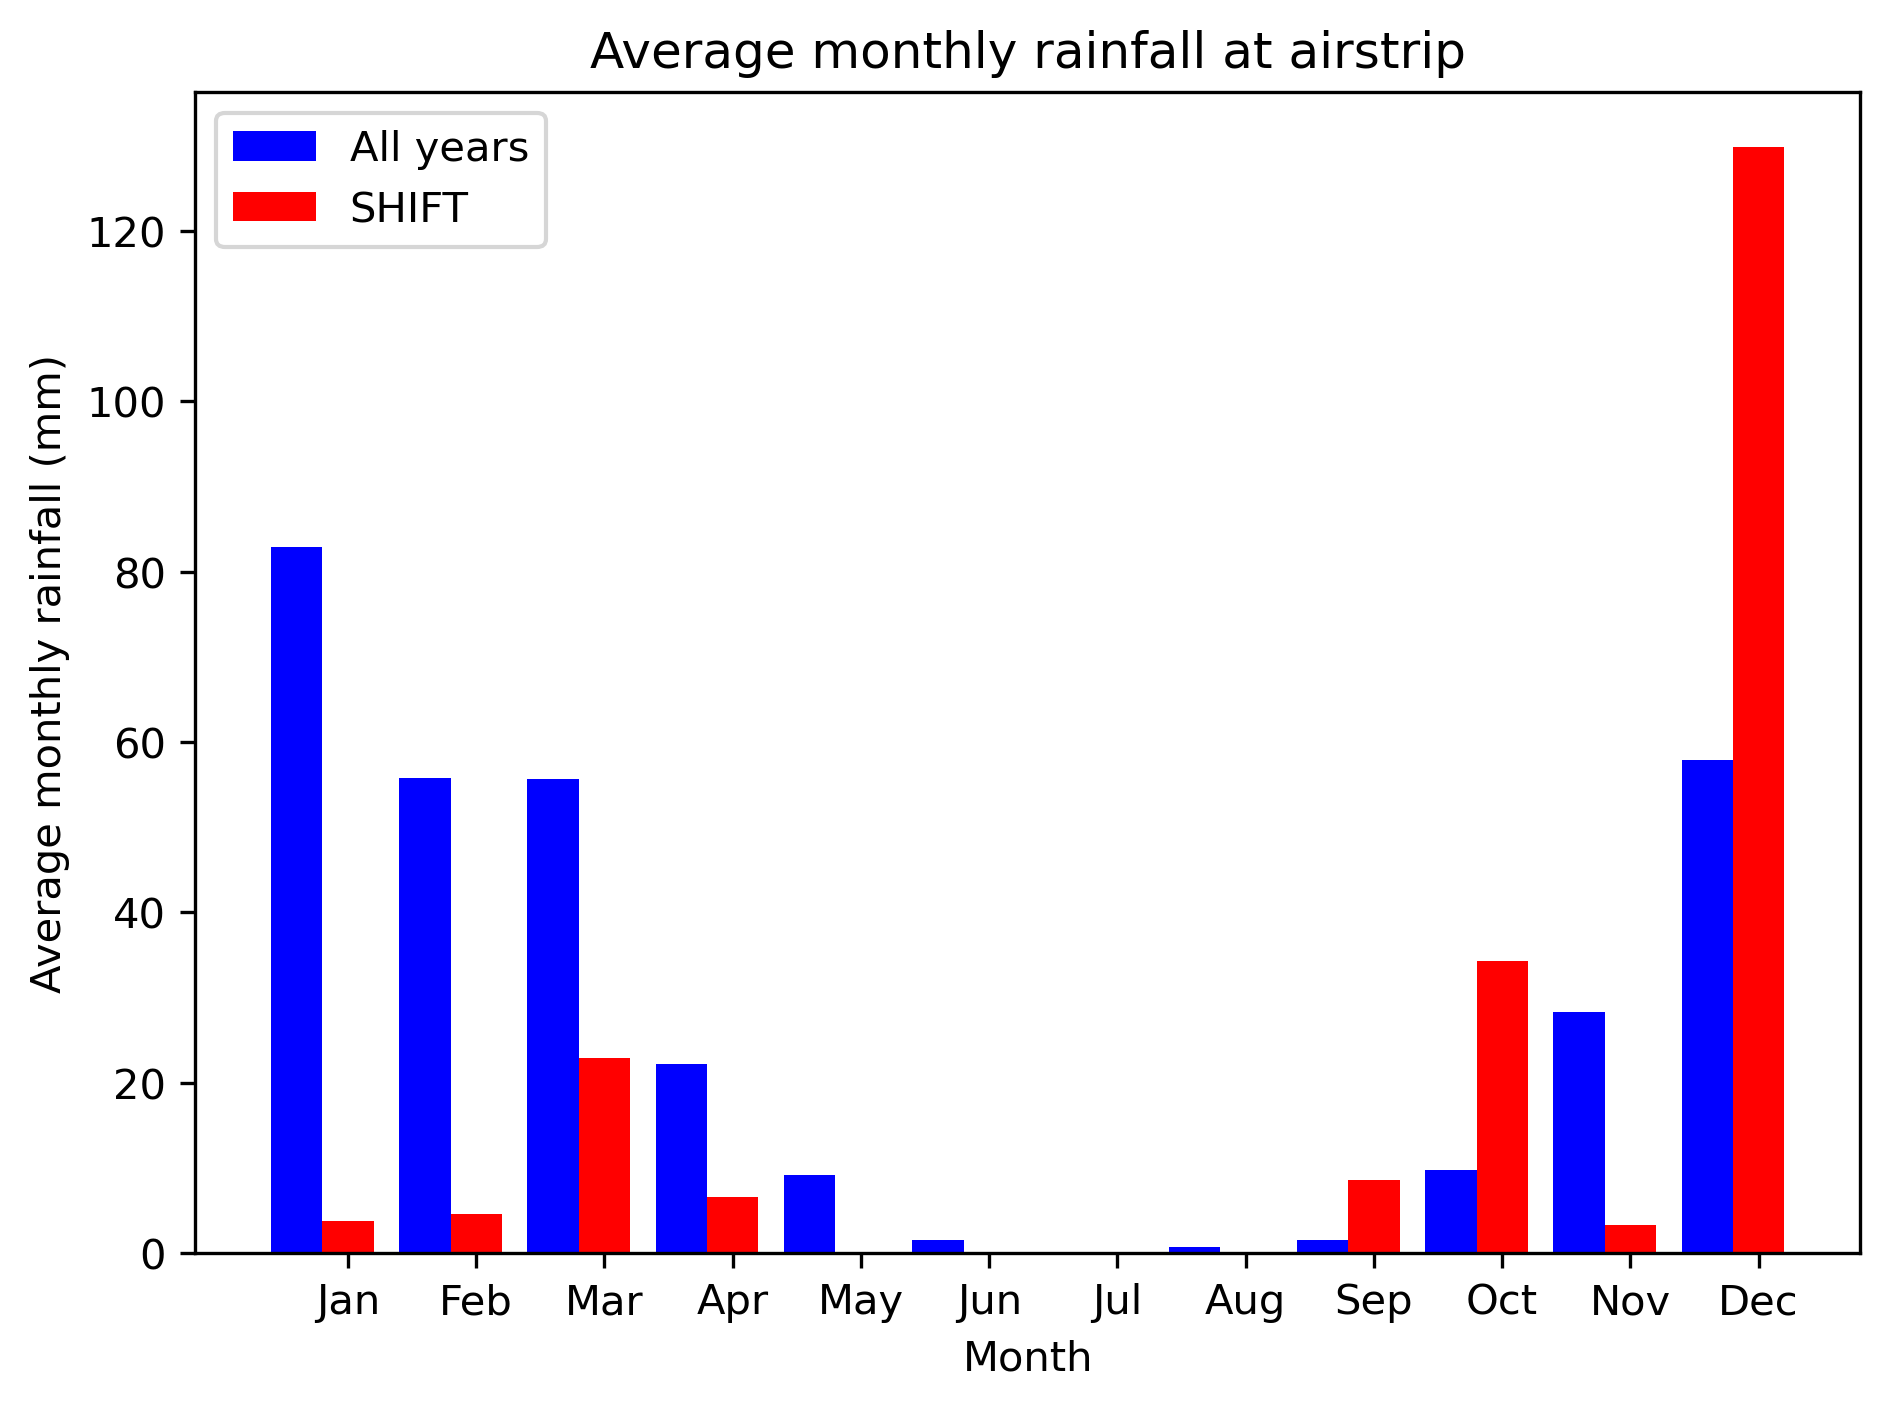

In [5]:
# bar chart of monthly averages across all years compared with SHIFT data
plt.figure()
plt.bar(np.arange(n_int)-0.4, np.mean(monthly_precips, axis=1), width=0.4, color='b')
plt.bar(np.arange(n_int), monthly_precips_shift, color='r', width=0.4)
plt.legend(['All years', 'SHIFT'])
plt.xlabel('Month')
plt.ylabel('Average monthly rainfall (mm)')
plt.title('Average monthly rainfall at airstrip')
plt.xticks(np.arange(n_int), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

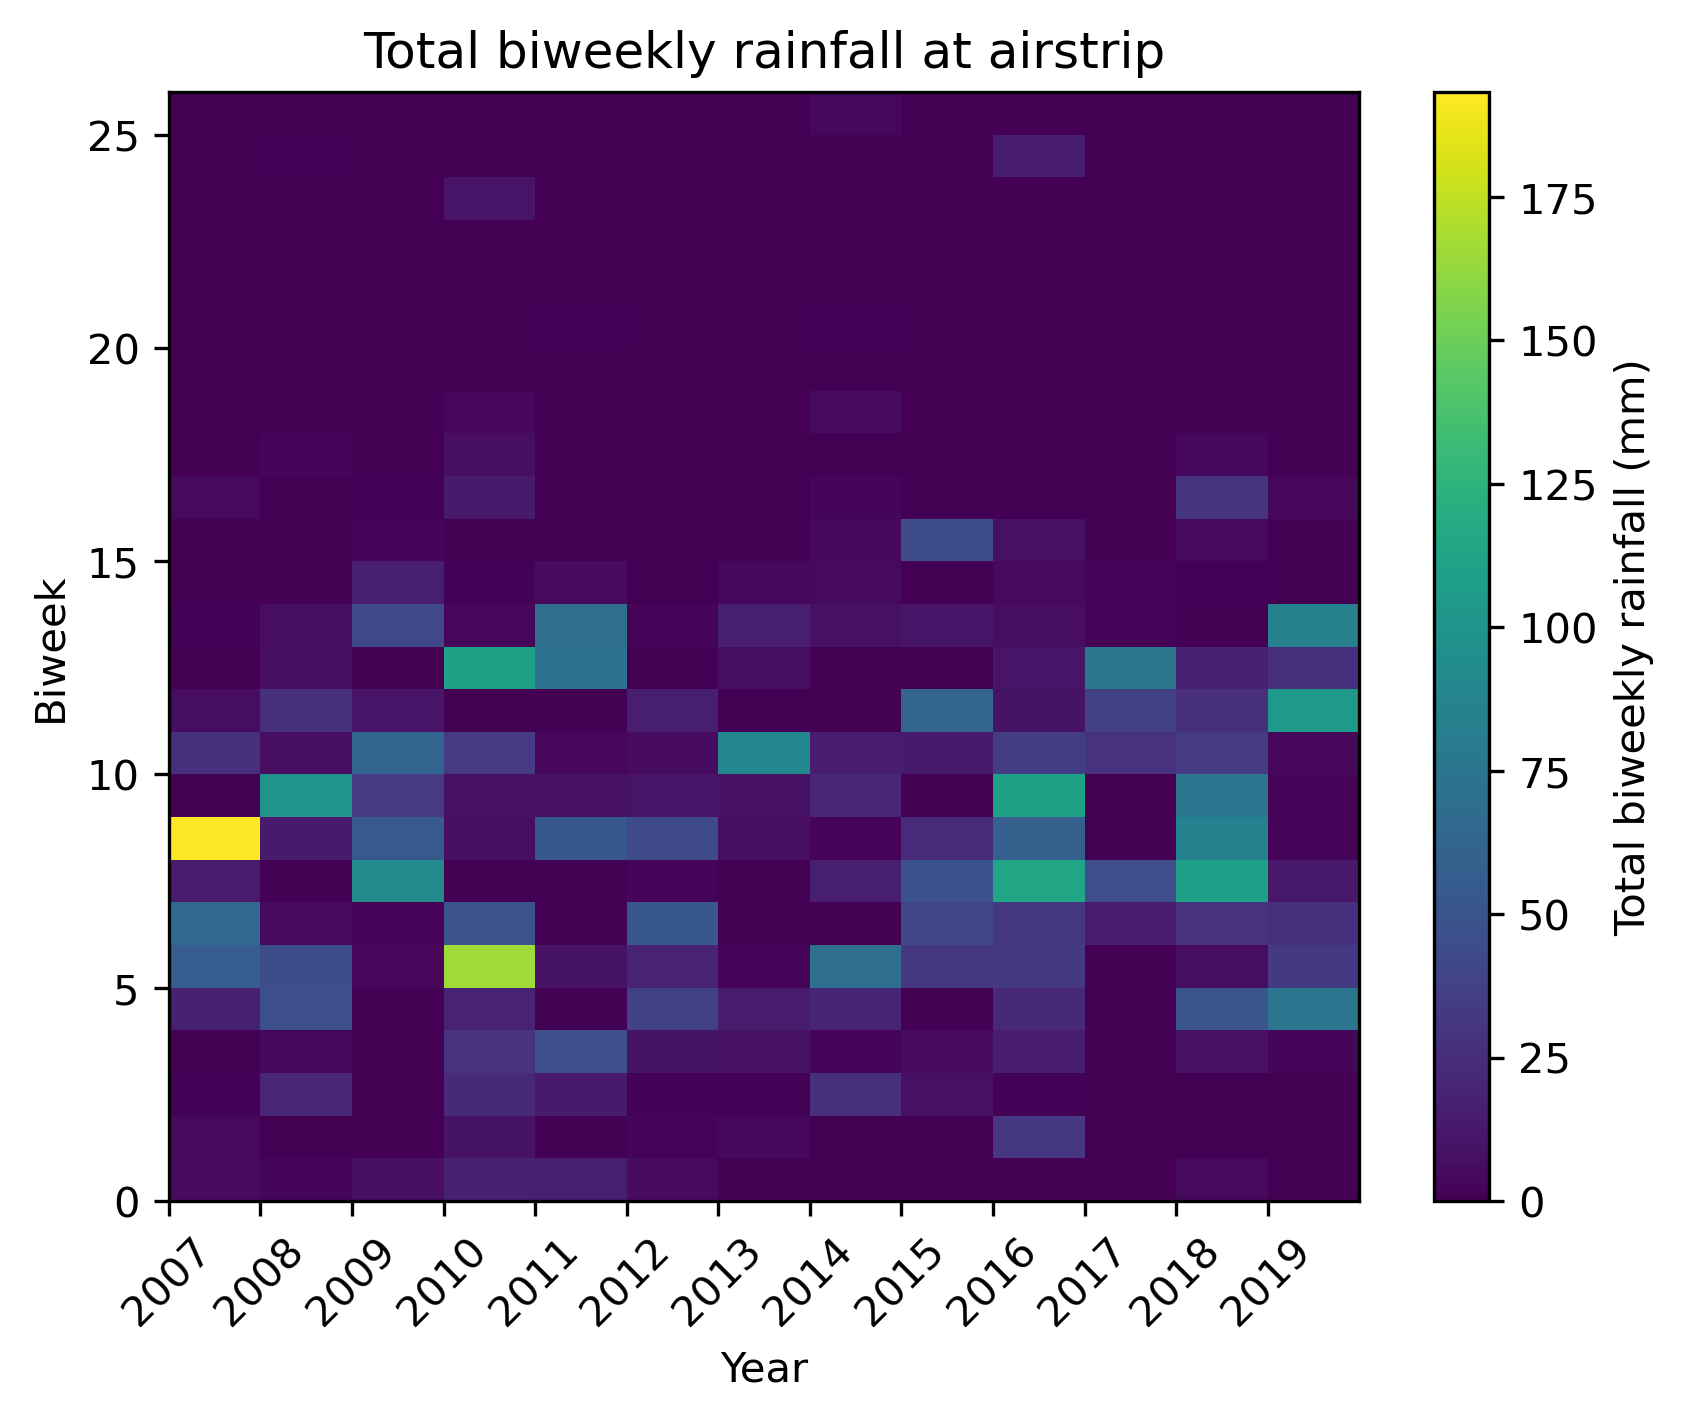

In [6]:
# try biweekly averages of precip
n_int = 26

biweekly_precips = np.zeros([n_int, len(met_dfs)])
biweekly_datetimes = []
start_date = datetime(2007, 10, 1)
for i in range(n_int):
    biweekly_datetimes.append(start_date + pd.DateOffset(weeks=2*i))

# get cumulative rainfall for each biweek for each year
for i in range(len(met_dfs)):
    for j in range(n_int):
        biweekly_precips[j, i] = met_dfs[i][(met_dfs[i]['datetime'] >= biweekly_datetimes[j]) & (met_dfs[i]['datetime'] < biweekly_datetimes[j] + pd.DateOffset(weeks=2))]['Precip'].sum()
    for j in range(n_int):
        biweekly_datetimes[j] = biweekly_datetimes[j] + pd.DateOffset(years=1)
    if biweekly_datetimes[0].year == 2020:
        for j in range(n_int):
            biweekly_datetimes[j] = biweekly_datetimes[j] + pd.DateOffset(years=1)
            
# get cumulative rainfall for each biweek for just SHIFT year
biweekly_precips_shift = np.zeros(n_int)
for j in range(n_int):
    biweekly_precips_shift[j] = met_df_shift[(met_df_shift['datetime'] >= biweekly_datetimes[j]) & (met_df_shift['datetime'] < biweekly_datetimes[j] + pd.DateOffset(weeks=2))]['Precip'].sum()


#colormesh..
plt.figure()
plt.pcolormesh(biweekly_precips, cmap='viridis')
plt.colorbar(label='Total biweekly rainfall (mm)')
plt.xlabel('Year')
plt.ylabel('Biweek')
plt.title('Total biweekly rainfall at airstrip')
plt.xticks(np.arange(len(met_dfs)), [f.split('_')[1].split('.')[0] for f in met_files[:-2]], rotation=45)
plt.show()

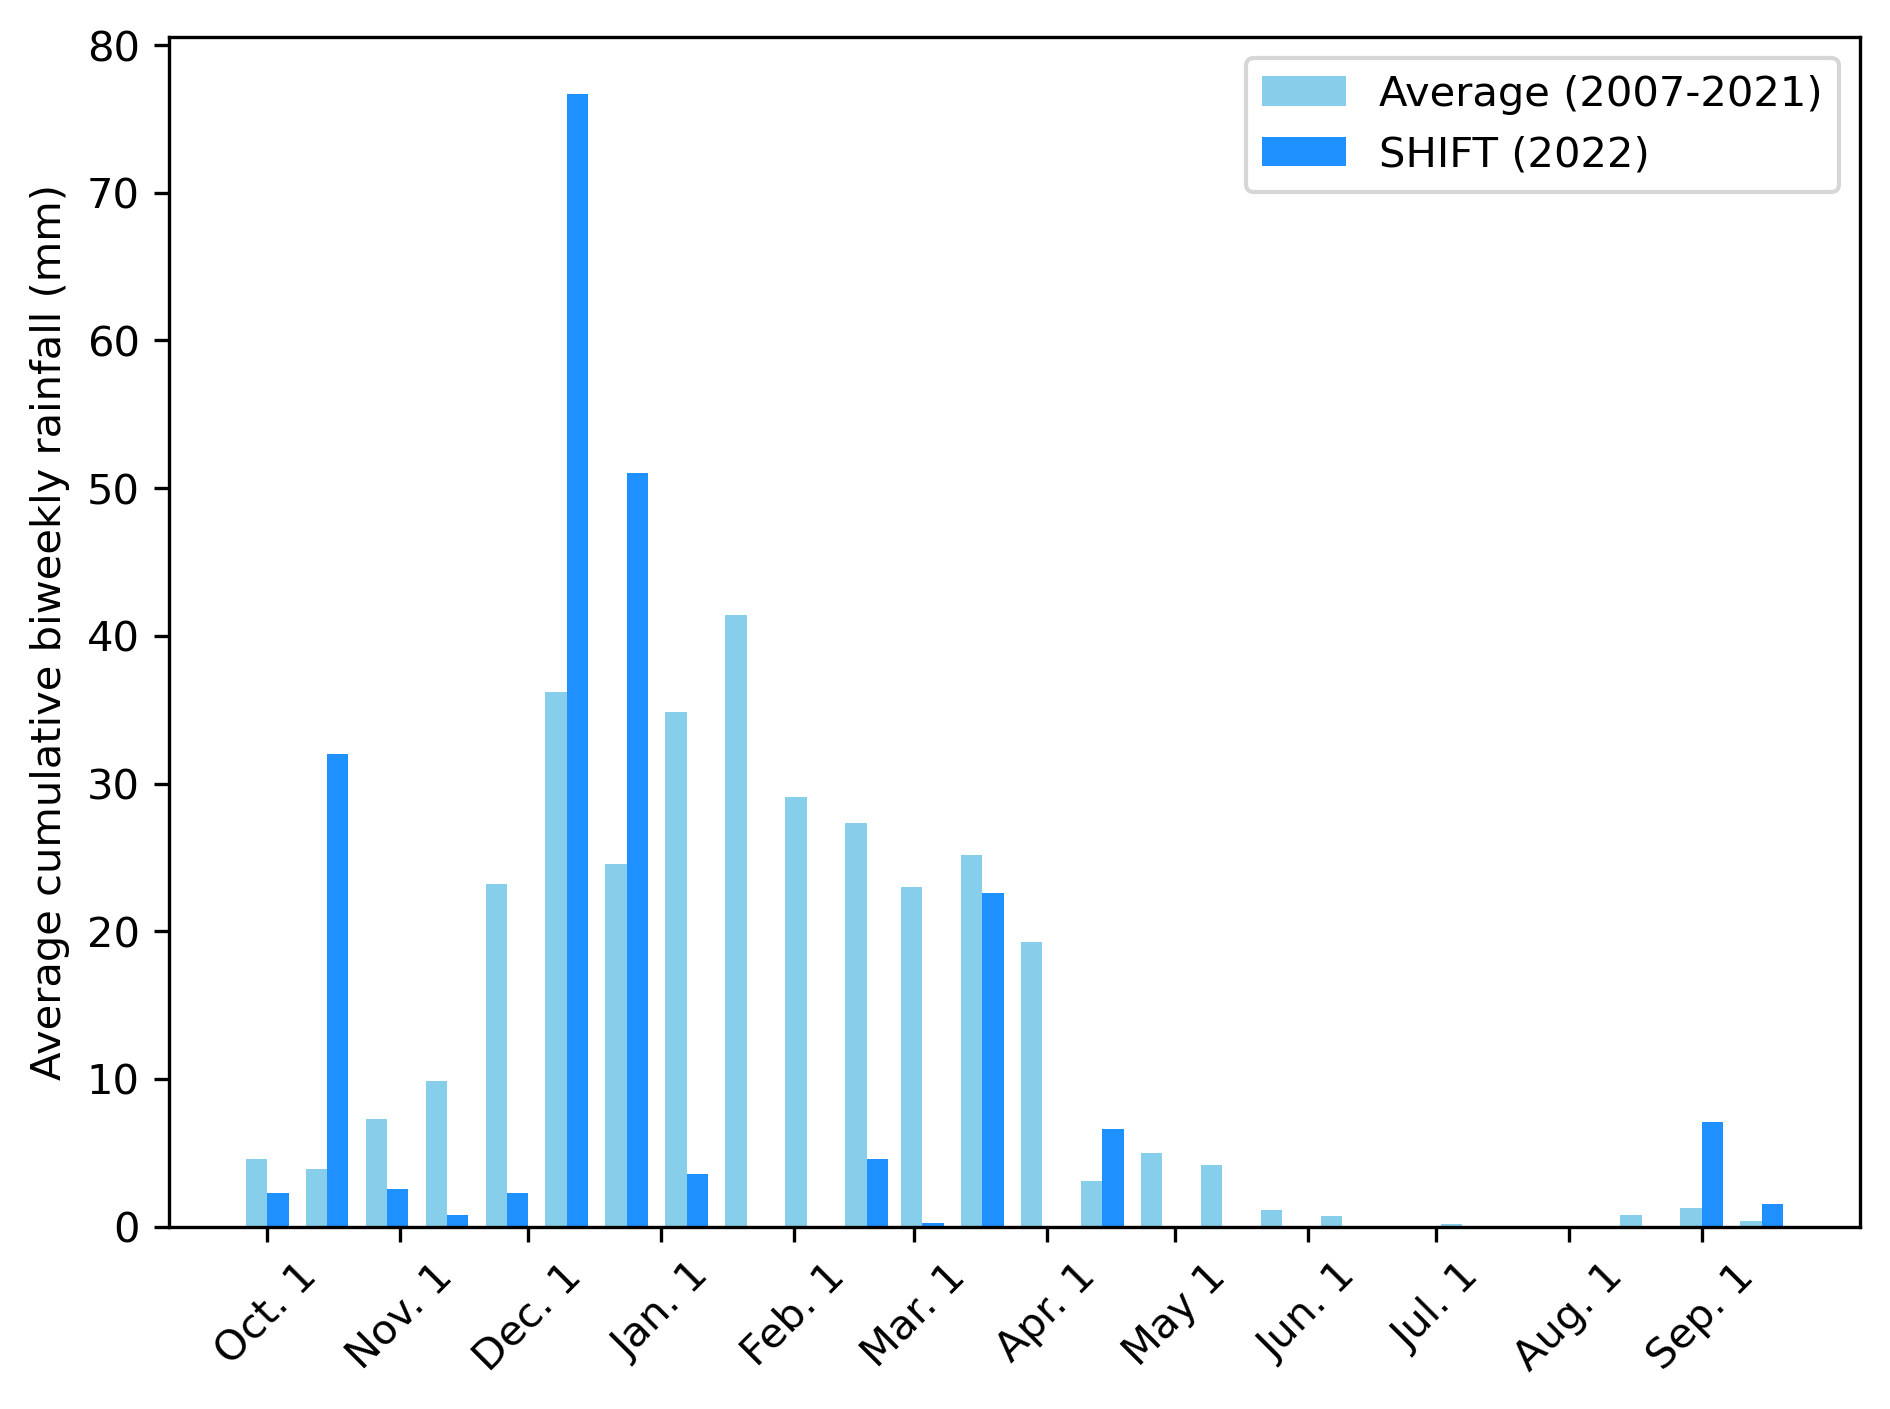

In [7]:
# bar chart of biweekly averages across all years
plt.figure()
plt.bar([date - pd.DateOffset(weeks=2.5/7) for date in biweekly_datetimes], np.mean(biweekly_precips, axis=1), width=5, color='skyblue', label = 'Average (2007-2021)')
plt.bar([date + pd.DateOffset(weeks=2.5/7) for date in biweekly_datetimes], biweekly_precips_shift, width=5, color='dodgerblue', label = 'SHIFT (2022)')
plt.ylabel('Average cumulative biweekly rainfall (mm)')
x_ticks_labels = ['Oct. 1', 'Nov. 1', 'Dec. 1', 'Jan. 1', 'Feb. 1', 'Mar. 1', 'Apr. 1', 'May 1', 'Jun. 1', 'Jul. 1', 'Aug. 1', 'Sep. 1']

# set ticks to only where the 1st of the month is
monthly_datetimes = [datetime(2021, i, 1) for i in range(10, 13)] + [datetime(2022, i, 1) for i in range(1, 10)]
plt.xticks(monthly_datetimes, x_ticks_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 3. Temperature

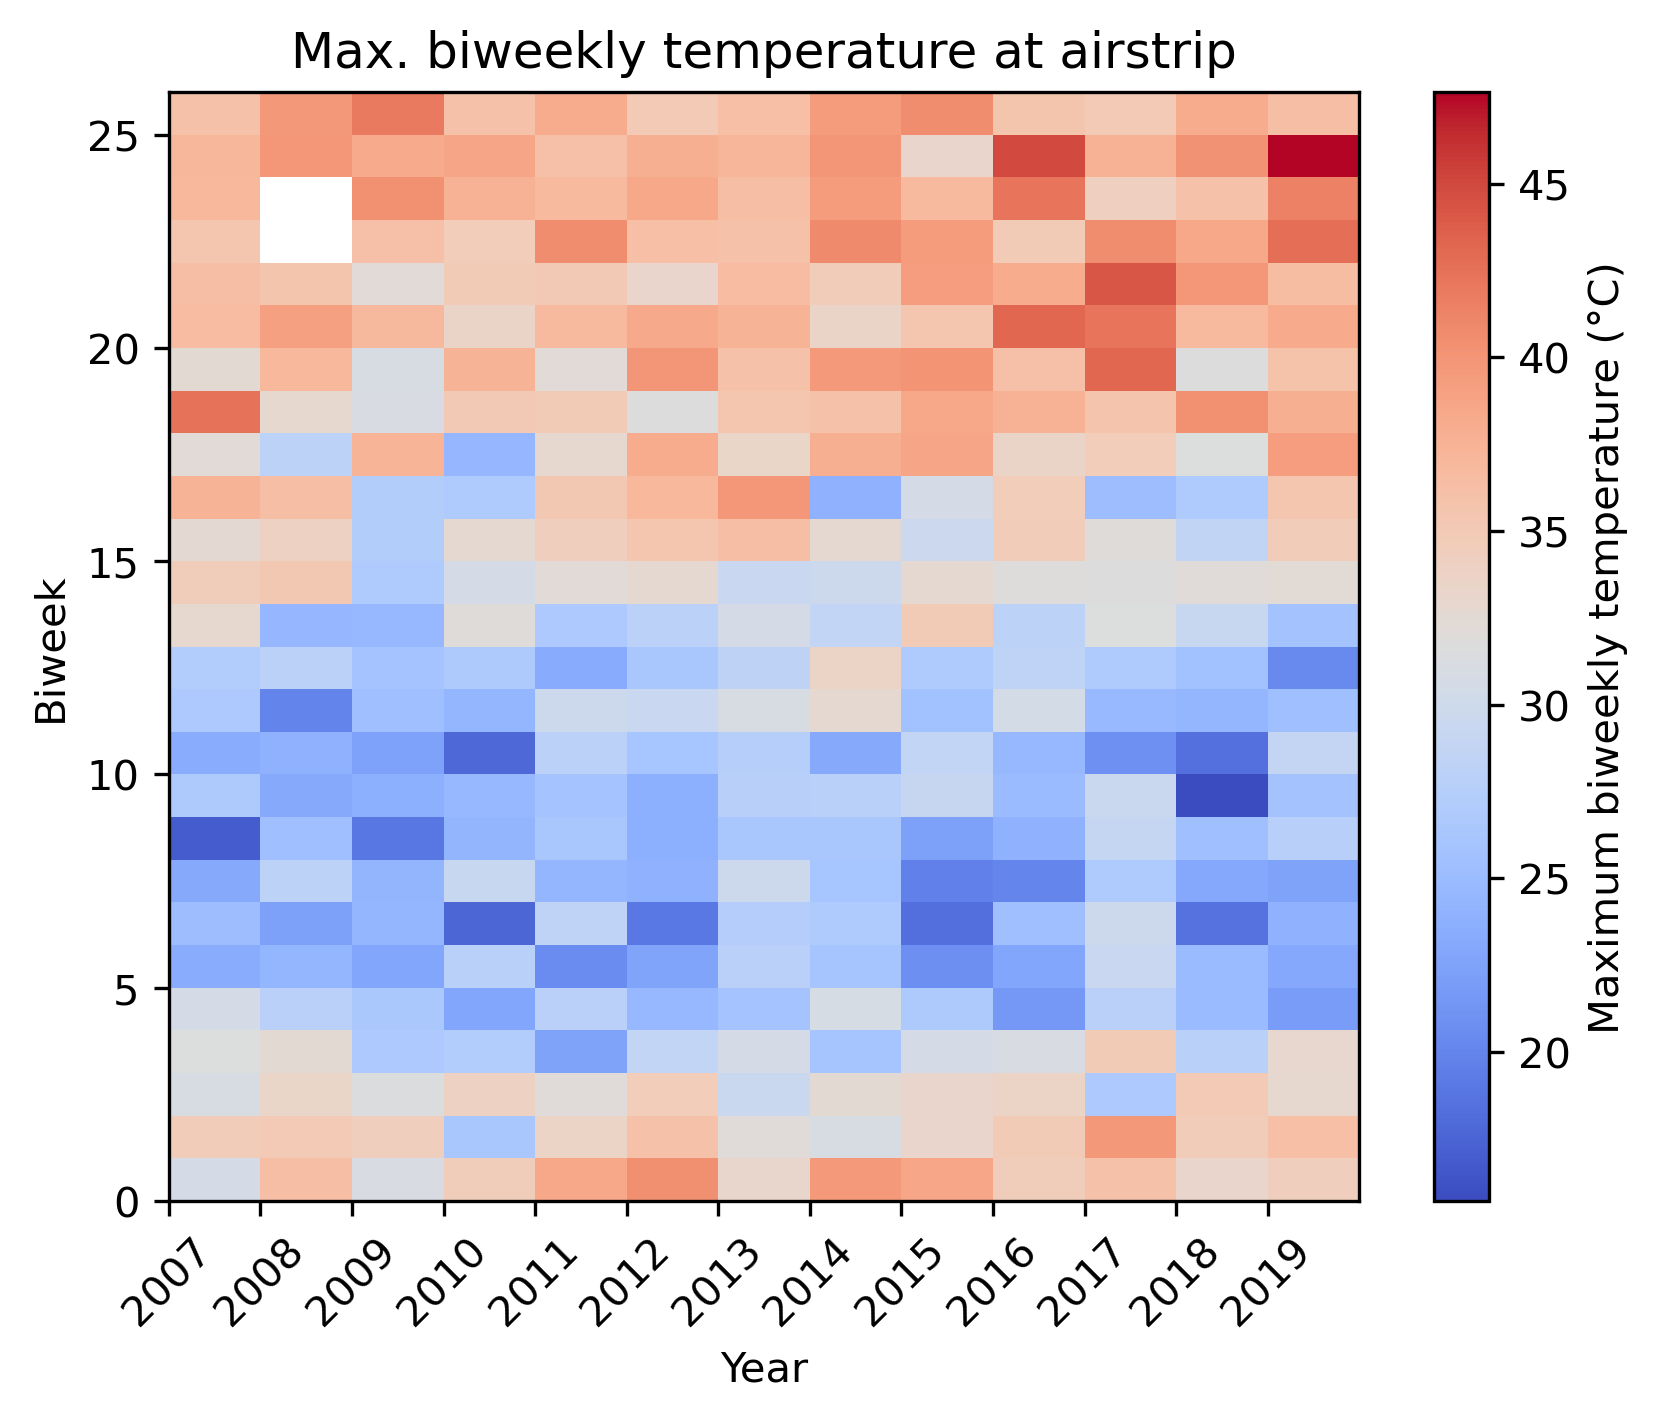

In [26]:
# average biweekly temperature
biweekly_temps = np.zeros([n_int, len(met_dfs)])
biweekly_datetimes = []
start_date = datetime(2007, 10, 1)
for i in range(n_int):
    biweekly_datetimes.append(start_date + pd.DateOffset(weeks=2*i))


# get max temperature for each biweek for each year
for i in range(len(met_dfs)):
    for j in range(n_int):
        biweekly_temps[j, i] = met_dfs[i][(met_dfs[i]['datetime'] >= biweekly_datetimes[j]) & (met_dfs[i]['datetime'] < biweekly_datetimes[j] + pd.DateOffset(weeks=2))]['Temp'].max()
    for j in range(n_int):
        biweekly_datetimes[j] = biweekly_datetimes[j] + pd.DateOffset(years=1)
    if biweekly_datetimes[0].year == 2020:
        for j in range(n_int):
            biweekly_datetimes[j] = biweekly_datetimes[j] + pd.DateOffset(years=1)


biweekly_datetimes = []
start_date = datetime(2021, 10, 1)
for i in range(n_int):
    biweekly_datetimes.append(start_date + pd.DateOffset(weeks=2*i))

# get max temperature for each biweek for SHIFT year
biweekly_temps_shift = np.zeros(n_int)
for j in range(n_int):
    biweekly_temps_shift[j] = met_df_shift[(met_df_shift['datetime'] >= biweekly_datetimes[j]) & (met_df_shift['datetime'] < biweekly_datetimes[j] + pd.DateOffset(weeks=2))]['Temp'].max()

# colormesh...
plt.figure()
plt.pcolormesh(biweekly_temps, cmap='coolwarm')
plt.colorbar(label='Maximum biweekly temperature (°C)')
plt.xlabel('Year')
plt.ylabel('Biweek')
plt.title('Max. biweekly temperature at airstrip')
plt.xticks(np.arange(len(met_dfs)), [f.split('_')[1].split('.')[0] for f in met_files[:-2]], rotation=45)
plt.show()

In [25]:
biweekly_temps_shift

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

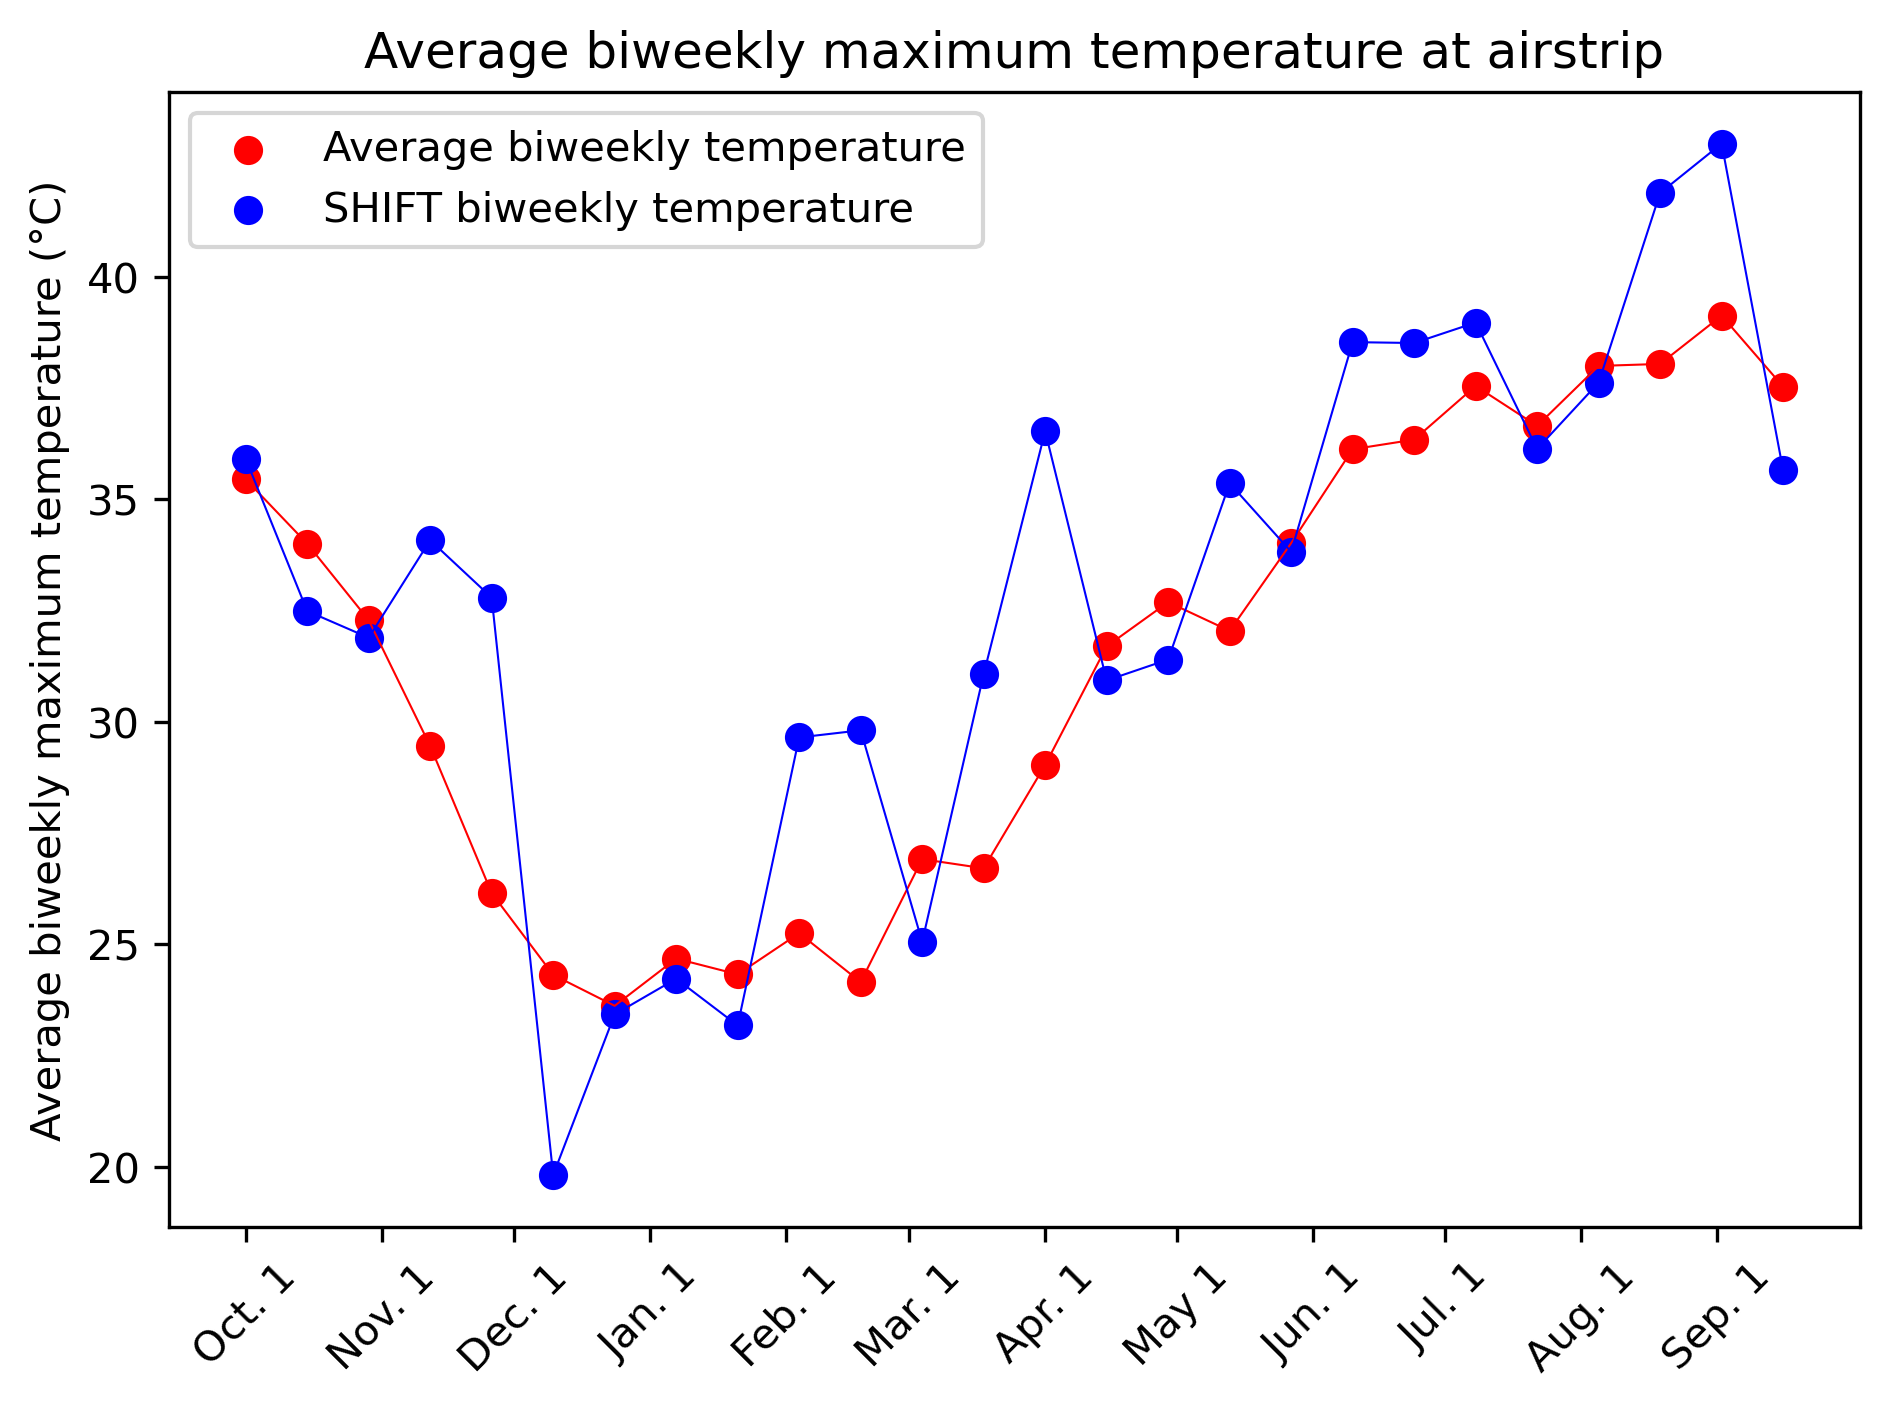

In [34]:
# line plot of biweekly averages across all years
plt.figure()
plt.scatter(biweekly_datetimes, np.nanmean(biweekly_temps, axis=1), color='r', label='Average biweekly temperature')
plt.plot(biweekly_datetimes, np.nanmean(biweekly_temps, axis=1), color='r', linewidth=0.5)
plt.scatter(biweekly_datetimes, biweekly_temps_shift, color='b', label='SHIFT biweekly temperature')
plt.plot(biweekly_datetimes, biweekly_temps_shift, color='b', linewidth=0.5)
plt.ylabel('Average biweekly maximum temperature (°C)')
plt.title('Average biweekly maximum temperature at airstrip')
plt.xticks(monthly_datetimes, x_ticks_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 4. Plot them together...

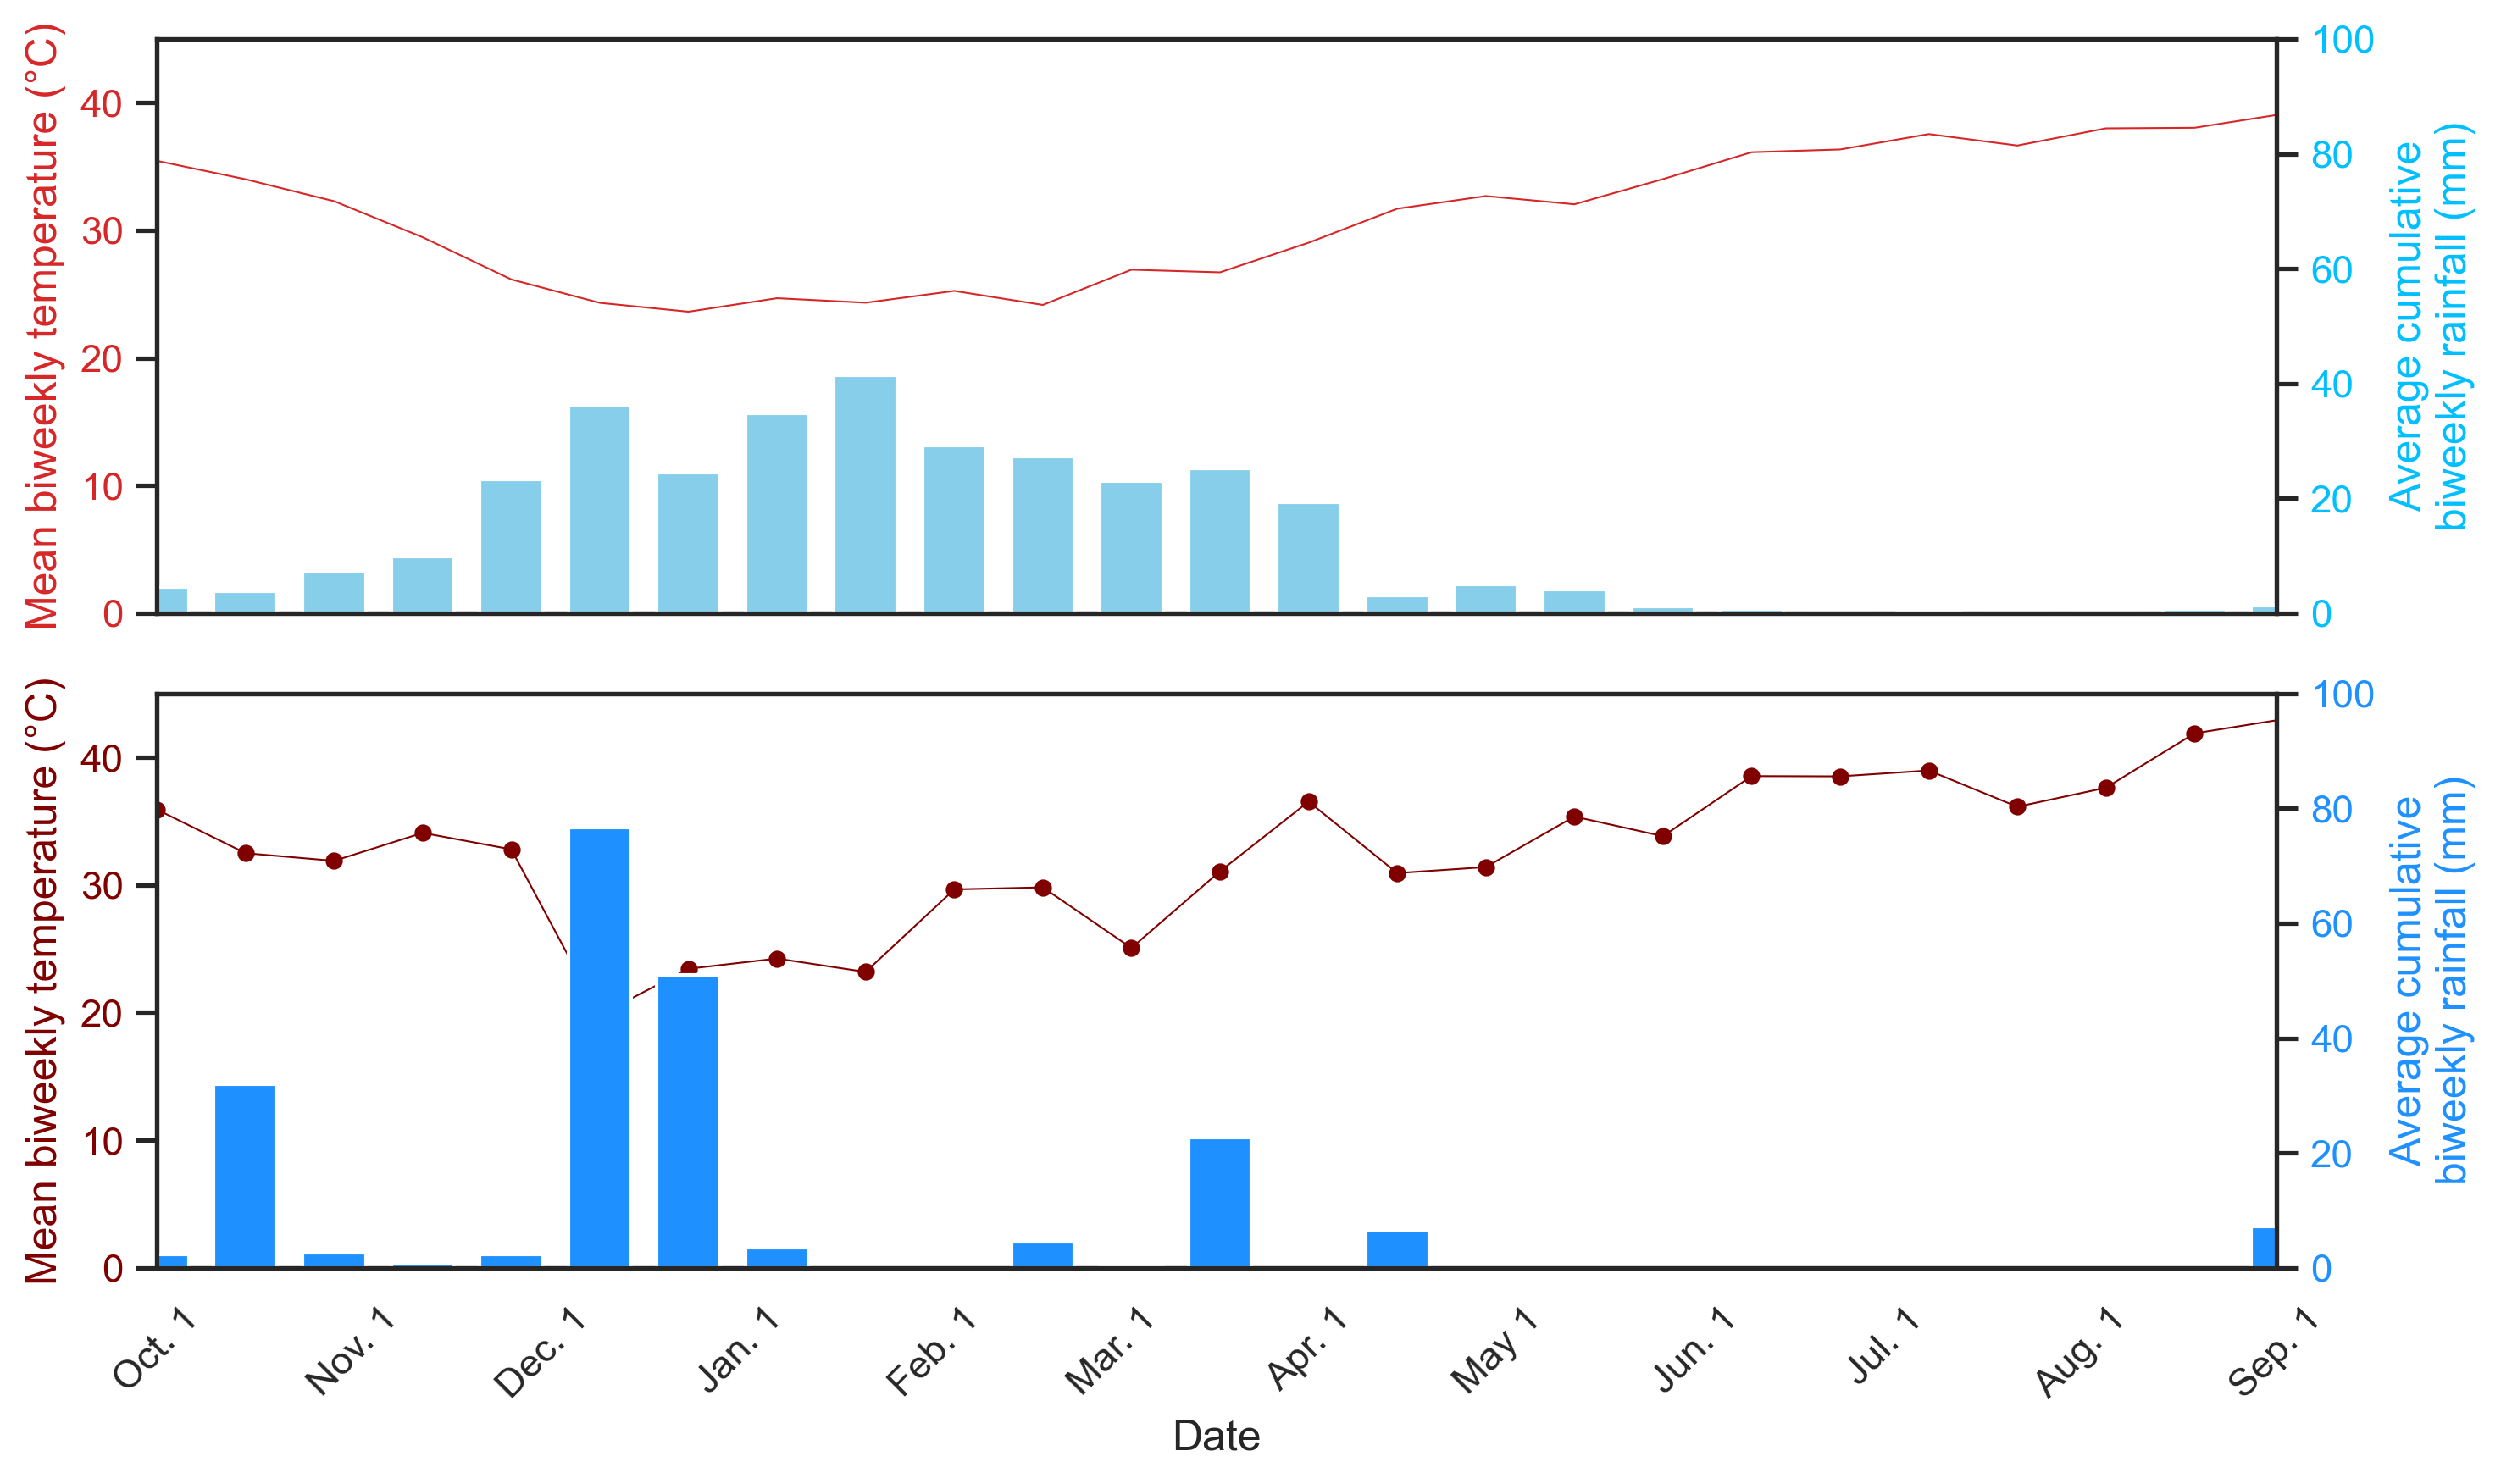

In [66]:
# Two separate plots
fig, [ax1, ax3] = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

sns.set(style="white")   # white, dark, whitegrid, darkgrid, ticks

color = 'tab:red'
# ax1.set_xlabel('Date')
ax1.set_ylabel('Mean biweekly temperature (°C)', color=color)
ax1.plot(biweekly_datetimes, np.nanmean(biweekly_temps, axis=1), color=color, linewidth=0.5, zorder=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(monthly_datetimes)
ax1.set_xticklabels(x_ticks_labels, rotation=45)
ax1.set_ylim([0, 45])
ax1.set_xlim([datetime(2021, 10, 1), datetime(2022, 9, 1)])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'skyblue'
ax2.set_ylabel('Average cumulative\nbiweekly rainfall (mm)', color='deepskyblue')  # we already handled the x-label with ax1
ax2.bar(biweekly_datetimes, np.mean(biweekly_precips, axis=1), capsize=5, width=10, color=color, label='Average biweekly rainfall', zorder=1)
ax2.tick_params(axis='y', labelcolor='deepskyblue')
ax2.set_ylim([0, 100])

# plot just 2022 SHIFT data on the next plot

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

color = 'dodgerblue'
ax4.set_ylabel('Average cumulative\nbiweekly rainfall (mm)', color=color)  # we already handled the x-label with ax1
ax4.bar(biweekly_datetimes, biweekly_precips_shift, capsize=5,
        width=10, color=color, label='SHIFT biweekly rainfall', zorder=1)
ax4.tick_params(axis='y', labelcolor=color)
ax4.set_ylim([0, 100])

color = 'maroon'
ax3.set_xlabel('Date')
ax3.set_ylabel('Mean biweekly temperature (°C)', color=color)
ax3.plot(biweekly_datetimes, biweekly_temps_shift, color=color, linewidth=0.5, zorder=2)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_xticks(monthly_datetimes)
ax3.set_xticklabels(x_ticks_labels, rotation=45)
ax3.set_ylim([0, 45])
ax3.set_xlim([datetime(2021, 10, 1), datetime(2022, 9, 1)])

# Draw scatter plot after bar chart to ensure it appears on top
ax3.scatter(biweekly_datetimes, biweekly_temps_shift, color=color, s=15, zorder=3)

fig.tight_layout()

# plt.savefig('met_biweekly_1.png')
plt.show()